In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Baseline Model

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)

6643712/6643618 [==============================] - 4s 1us/step


In [3]:
label_index_dict = atti_dataset.get_label_index()

8192/1595 [==========================================================================================================================================================] - 0s 0us/step


Add one because the array is zero based

In [5]:
num_words = max([max(x) for x in x_train]) + 1
num_words

34731

In [6]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 28 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO 

## Data Preparation

create the function to trasnform the x data

In [7]:
from functools import partial

def x_transformer(x_data):
    return partial(dataset_utils.vectorize_sequences, x_data, num_words)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [8]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 28
training size 97726, validation size 24431


Create the iterator for the training and validaton set

In [9]:
train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

In [10]:
def build_model(neurons, num_words, num_classes):
    keras_util.new_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation='relu', input_shape=(num_words, )))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

### Evaluate the Classifier on the following architectures

In [11]:
neurons_size = [32, 64, 128]

In [12]:
def train(neurons_size, epochs):
    histories = {}
    for neuron in neurons_size:
        print('*** Network with {} ***'.format(neuron))
        model = build_model(neuron, num_words, num_classes)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/dense_{}".format(neuron)),
            tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
                    ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)
        
        histories[str(neuron)] = history

Define the number of steps per epochs

In [13]:
!rm -rf logs/*

In [14]:
histories = train(neurons_size, 10)

*** Network with 32 ***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1111424   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                924       
Total params: 1,114,460
Trainable params: 1,114,460
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
764/764 [==============================] - 28s 37ms/step - loss: 1.1926 - acc: 0.6574 - val_loss: 0.7793 - val_acc: 0.7508
Epoch 2/10
764/764 [==============================] - 28s 37ms/step - loss: 0.4927 - acc: 0.8465 - va

## Build the final model

the best model is obtained with 128 neurons and 3 epochs

In [15]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [16]:
model = build_model(128, num_words, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4445696   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 28)                3612      
Total params: 4,482,332
Trainable params: 4,482,332
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit_generator(train_generator, train_steps, 2)

Epoch 1/2
955/955 [==============================] - 76s 80ms/step - loss: 0.7648 - acc: 0.7653
Epoch 2/2
955/955 [==============================] - 82s 85ms/step - loss: 0.3233 - acc: 0.8937


## Evaluate on the test set

In [18]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [19]:
test_predictions = model.predict(x_test_v, verbose=1)

30540/30540 [==============================] - 6s 208us/step


In [20]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.8123444662737394
precision  0.8166924765384725
recall  0.8123444662737394
f-measure  0.8132666244245011


### Report the classification result for each class

In [21]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.35      0.62      0.45       158
          1       0.70      0.50      0.58       217
          2       0.84      0.91      0.88       686
          3       0.79      0.81      0.80      2765
          4       0.86      0.75      0.80      1658
          5       0.70      0.67      0.68       289
          6       0.65      0.63      0.64       606
          7       0.51      0.54      0.52       316
          8       0.75      0.73      0.74       669
          9       0.85      0.78      0.81      1432
         10       0.71      0.82      0.76       542
         11       0.69      0.75      0.72       767
         12       0.68      0.82      0.74       985
         13       0.96      0.95      0.96      2718
         14       0.79      0.82      0.80       370
         15       0.93      0.93      0.93      1142
         16       0.85      0.85      0.85      1890
         17       0.70      0.70      0.70   

### Confusion Matrix

In [22]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [23]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


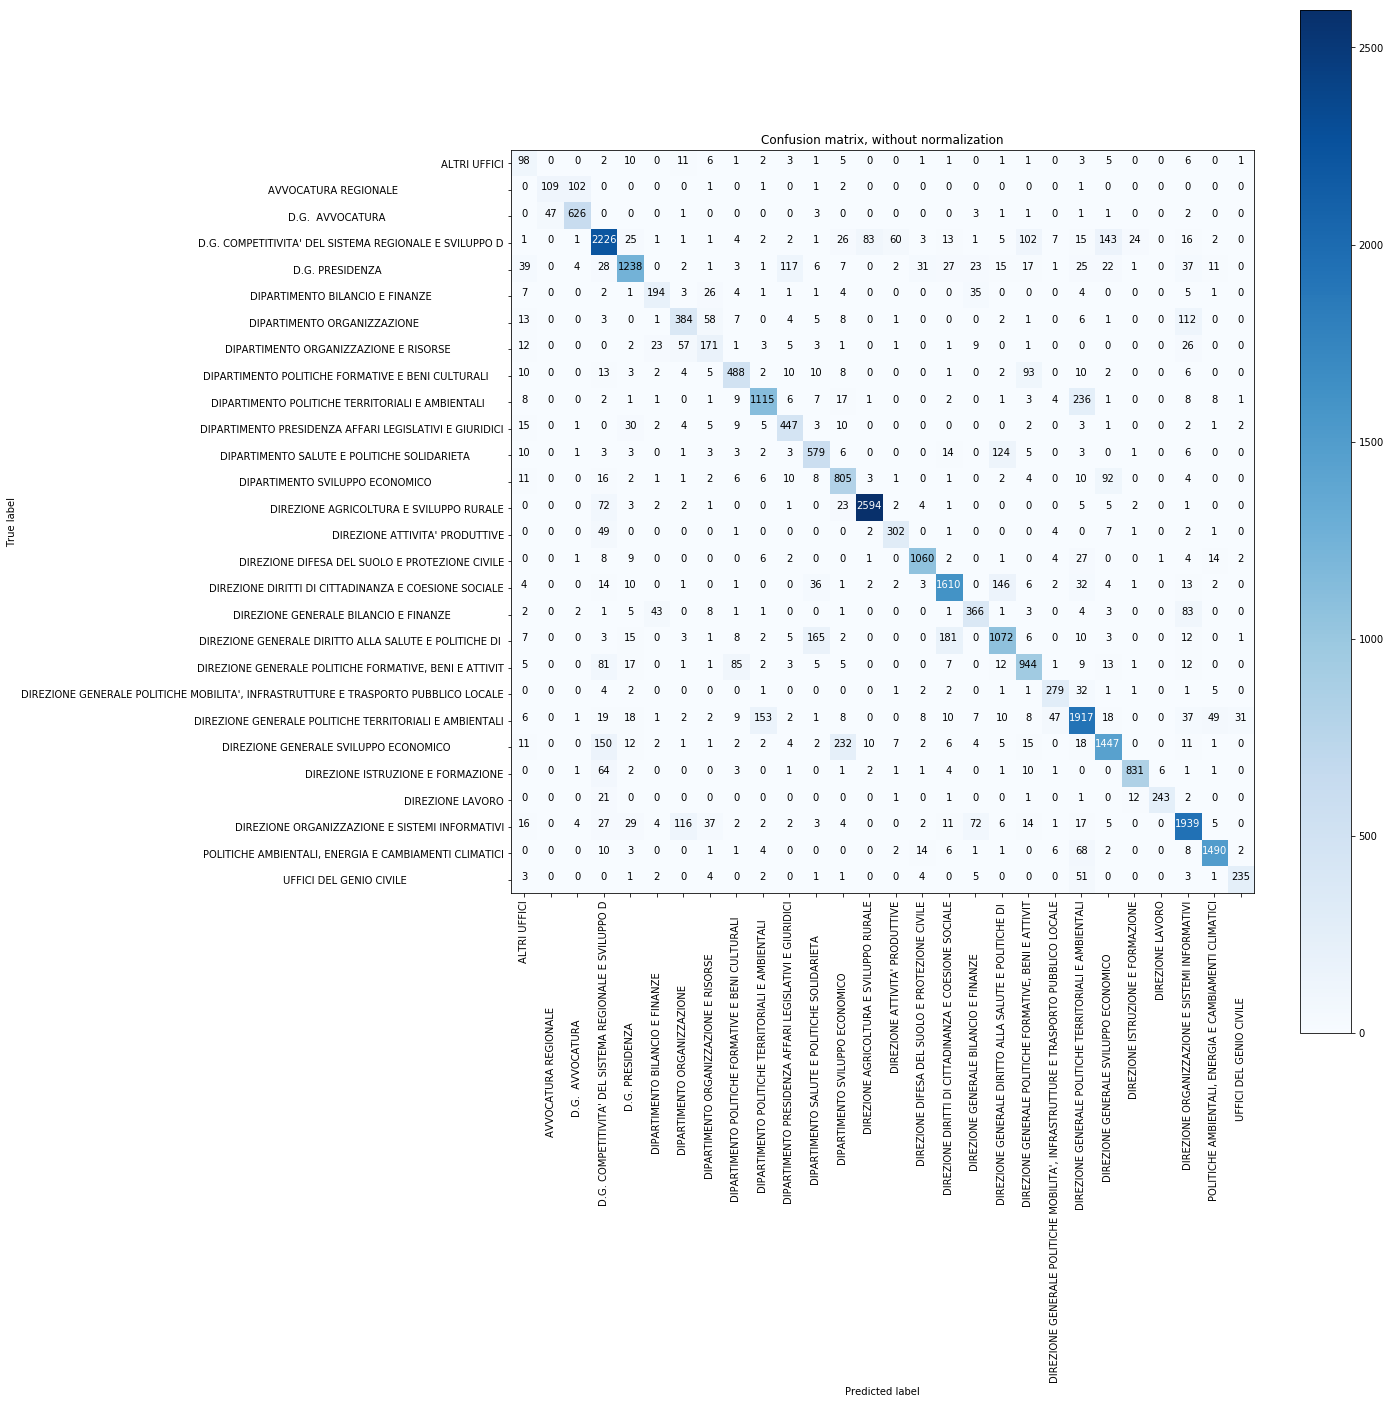

In [24]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')

In [25]:
model.save('../checkpoints/baseline.hdf5')